Geetting CMIP6 using the cutout function. Waleed has done it like: 
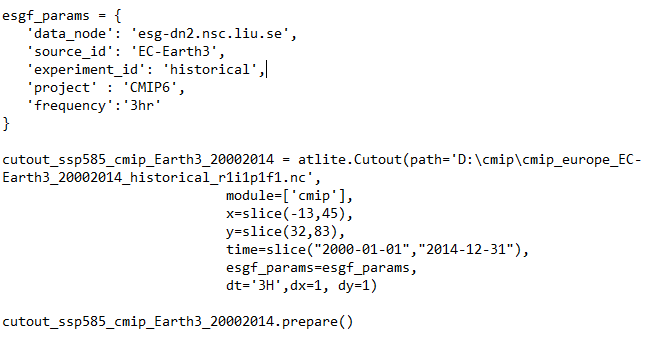

Using example from Ovewh: https://github.com/Ovewh/atlite/blob/cmip/examples/cmip_interface_example.ipynb

In [7]:
##### IMPORTING STUFF #####
from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
import xarray as xr
import atlite
import logging
import cdsapi
from cartopy.io import shapereader
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)
import numpy as np
import pandas as pd

In [8]:
##### CREATING EUROPE SHAPEFILE #####
def natural_earth_shapes_EU(join_dict, drop_non_Europe=['MA','DZ','TN','GI']):
    # Download shape file (high resolution)
    shpfilename = shapereader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_1_states_provinces')

    
    df =gpd.read_file(shpfilename)
    df = df.cx[-13:32,35:80]
    df = df[['iso_a2','geometry']]
    df = df.dissolve('iso_a2')
    df.index = list(df.index)
    drop_regions = drop_non_Europe
    # Absorbe microstates
    for main_r,sub_rs in join_dict.items():
        temp_main = df.loc[main_r,'geometry']
        for sub_r in sub_rs:
            drop_regions.append(sub_r)
            temp_r = df.loc[sub_r,'geometry']
        
            temp_main = temp_main.union(temp_r)
        temp_main = gpd.GeoSeries([temp_main])
        df.loc[[main_r],'geometry'] = temp_main.values
    
    df = df.drop(index=drop_regions)
    return df

In [9]:
join_dict = {'FR':['GG','AD','MC'],'IT':['VA','SM'], 'GB':['JE','IM'],'FI':['AX'],'DK':['FO'],
            'CH':['LI'], 'BE':['LU'],'RS':['XK']}
europe = natural_earth_shapes_EU(join_dict)

# CMIP Solar capacities (from example)
Ove's example uses the EC-Earth3 model at a 3hr frequency. 

In [15]:
esgf_params = {
   'data_node': 'esgf-cnr.hpc.cineca.it',
   'source_id': 'EC-Earth3',
   'variant_label':'r4i1p1f1',
   'experiment_id': 'ssp126',
   'project' : 'CMIP6',
   'frequency':'3hr'
}

conn = SearchConnection('https://esgf-data.dkrz.de/esg-search')
ctx = conn.new_context(facets='project,experiment_id')

cutout_cmip = atlite.Cutout(path='cmip_europe_2031.nc',module=['cmip'],
                      x=slice(-13,45),
                      y=slice(32,83),
                           time='2031-01',
                           esgf_params=esgf_params,
                           facets = ['project', 'model'],
                           dt='3H',dx=1, dy=1)

Making a dataset with  time, x and y. 

In [16]:
ds = xr.Dataset(
    {
        "x": np.round(np.arange(-180, 180, 1), 9),
        "y": np.round(np.arange(-90, 90, 1), 9),
        "time": pd.date_range(start='2015', end='2100', freq='3H'),
    }
)
ds

<xarray.Dataset>
Dimensions:  (x: 360, y: 180, time: 248369)
Coordinates:
  * x        (x) int32 -180 -179 -178 -177 -176 -175 ... 174 175 176 177 178 179
  * y        (y) int32 -90 -89 -88 -87 -86 -85 -84 -83 ... 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 2015-01-01 2015-01-01T03:00:00 ... 2100-01-01
Data variables:
    *empty*

In [17]:
cutout_cmip.prepare()


-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly use  conn.new_context(facets='*')

-------------------------------------------------------------------------------

----------------------------------------------------

ValueError: When combine='by_coords', passing a value for `concat_dim` has no effect. To manually combine along a specific dimension you should instead specify combine='nested' along with a value for `concat_dim`.

In [18]:
cutout_cmip.data

<xarray.Dataset>
Dimensions:  (x: 59, y: 52, time: 248)
Coordinates:
  * x        (x) int32 -13 -12 -11 -10 -9 -8 -7 -6 ... 38 39 40 41 42 43 44 45
  * y        (y) int32 32 33 34 35 36 37 38 39 40 ... 75 76 77 78 79 80 81 82 83
  * time     (time) datetime64[ns] 2031-01-01 ... 2031-01-31T21:00:00
    lon      (x) int32 -13 -12 -11 -10 -9 -8 -7 -6 ... 38 39 40 41 42 43 44 45
    lat      (y) int32 32 33 34 35 36 37 38 39 40 ... 75 76 77 78 79 80 81 82 83
Data variables:
    *empty*
Attributes:
    module:             ['cmip']
    prepared_features:  []
    chunksize_time:     100
    facets:             ['project', 'model']
    dt:                 3H
    dx:                 1
    dy:                 1

# FIXING WITH CHATGBT